# Wind Energy Prediction

The aim of this problem is to predict the hourly wind power generation for a wind farm.

Attribute Information:

Data for two years are given in two csv files with a first column with a datetime and the rest with headers

`['10u', '10v', '2t', 'sp', '100u', '100v', 'vel10', 'vel100', 'targ']`


where

* `targ` is the wind energy production normalized to a [0., 1.] range.
* `10u,10v, 100u, 100v` are the U (west-east) and V (south-north) wind components in m/s at heights 10 m and 100 m.
* `vel10,vel100` are the absolute wind speeds in m/s at heights 10 and 100 meters.
* `2t,sp` are surface temperature and pressure.

In order to simplify our computations, we are going to drop the `10, 10v, vel10` columns, but add three new variables:

* the sine and cosine of the wind at 100 meters.
* the cube of the `vel100` variable, as theoretically the energy of the wind that hits the blades is proportional to the cube of wind speed.

Thus our final eight variables must be:

* `100u, 100v`, the U (west-east) and V (south-north) wind components in m/s at height 100 m.
* `vel100`, the absolute wind speeds in m/s at height 100 meters.
* `vel100_3`, the cube of `vel100`.
* `s100, c100`, the sine and cosine of the wind direction at height 100 meters.
* `2t,sp`, surface temperature and pressure.

We are going to work with data fromn the years 2016, 2017 and 2018. Years 2016 and 2017 will be used for train and validation, and the year 2018 for test.

In [1]:
%matplotlib inline

In [2]:
import time

import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import clone

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Helper Functions

In [3]:
def gridsearch_create(model, model_name: str, param_grid: dict):
    """
    Wrapper for the creation of a GridSearchCV for a given model. Specifies
    the search to occur under a 2-fold non-shuffled cross validation, the
    transform and inverse_transform operations to be applied on the data. 

    Args:
        model: Regression model instance.  
        model_name (str): Name to use for the regressor model in the Pipeline.
        param_grid (dict): Hyperparameter combinations to select from.

    Returns:
        A sklearn.model_selection.GridSearchCV object. Running the fit()
        method on this object will utilize all available CPU cores for
        training.
    """
    regr = Pipeline(steps=[('std_sc', StandardScaler()), (model_name, model)])
    estimator = TransformedTargetRegressor(regressor=regr, transformer=StandardScaler())
    return GridSearchCV(estimator, 
                        param_grid=param_grid, 
                        cv=kf, 
                        scoring='neg_mean_absolute_error',
                        return_train_score=True,
                        refit=True,
                        n_jobs=-1, 
                        verbose=1)

def comparative_plot(df, param: str, p1: str, p2: str, v1, v2, nrows: int, ncols: int, index: int):
    """
    Creates comparative plots between a varying `param` and optimal,
    fixed `p1` and `p2` values.

    Args:
        df: Dataframe containing cross-validation results.
        param (str): Hyperparameter name.
        p1 (str): Fixed hyperparameter A name.
        p2 (str): Fixed hyperparameter B name.
        v1: Fixed hyperparameter A value.
        v2: Fixed hyperparameter B value.
        nrows (int): Number of rows in subplot.
        ncols (int): Number of columns in subplot.
        index (int): Current subplot.
    """
    plt.subplot(nrows, ncols, index)
    plt.title(f'{param}_vs_mae')
    plt.xlabel(param)
    plt.ylabel('cv mae')
    plt.xscale('log')
    
    fixed_idx = np.logical_and(df[f'param_regressor__svr__{p1}'] == v1, 
                               df[f'param_regressor__svr__{p2}'] == v2)
    _ = plt.plot( df[fixed_idx][f'param_regressor__svr__{param}'], 
                 -df[fixed_idx]['mean_test_score'], marker='o')


## Data Loading

Leer los datos 

In [4]:
data_dir = ''
d_years = {}
for yy in ['2016', '2017', '2018']:
    f_name = 'df_' + yy + '.csv'
    print(f_name)
    d_years[yy] = pd.read_csv(data_dir + f_name, sep=',', parse_dates=True, index_col=0)

df_2016.csv
df_2017.csv
df_2018.csv


Eliminar y añadir nuevas variables

In [5]:
for yy in ['2016', '2017', '2018']:
    # Eliminar columnas innecesarias
    d_years[yy].drop(columns=['10u','10v','vel10'], inplace=True)

    # Calcular dirección del viento desde U,V (en radianes). Con arctan2 no es necesario saber alpha.
    # dir = arctan(u/v) + alpha
    wdir = np.degrees(np.arctan2(d_years[yy]['100v'], d_years[yy]['100u']))
    
    d_years[yy]['s100'], d_years[yy]['c100'] = np.sin(wdir), np.cos(wdir)
    d_years[yy]['vel100_3'] = np.power(d_years[yy]['vel100'], 3)
    

# Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms over the 2016 data

### Descriptive analysis

In [6]:
d_years['2016'].describe().T

count          mean         std           min           25%  \
2t        8784.0    284.601271    5.414618    271.341797    280.528076   
sp        8784.0  95950.397733  769.800555  93148.187500  95537.625000   
100u      8784.0      0.001086    5.418696    -13.399642     -4.114265   
100v      8784.0      0.515967    4.539365    -12.669861     -2.927390   
vel100    8784.0      6.364048    3.119077      0.138182      4.112724   
targ      8784.0      0.161248    0.200789      0.000000      0.007219   
s100      8784.0      0.003782    0.704672     -1.000000     -0.695525   
c100      8784.0     -0.008326    0.709554     -1.000000     -0.725291   
vel100_3  8784.0    467.287599  742.257350      0.002638     69.564647   

                   50%           75%           max  
2t          283.940552    288.080872    306.323730  
sp        96023.937500  96418.437500  98034.562500  
100u         -0.430182      3.922256     20.653137  
100v         -0.160658      3.620473     16.700782  
vel100        5.994425      8.095730     21.213394  
targ          0.080859      0.236520      0.882954  
s100          0.014313      0.707651      1.000000  
c100         -0.003374      0.699602      1.000000  
vel100_3    215.398466    530.601027   9546.198592

## Boxplots

Normalize the data so that all boxplots are in a similar scale.

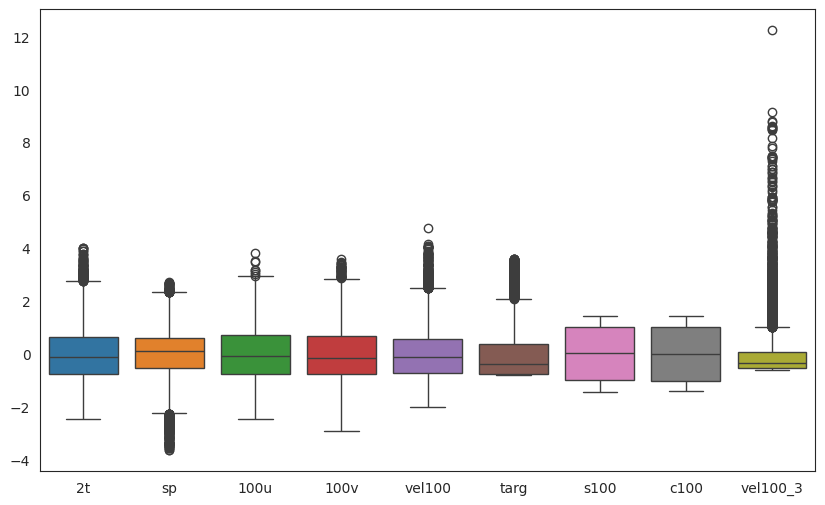

In [7]:
plt.figure(figsize=(10, 6))
sns.set_style("white")
bx_plot = sns.boxplot(data=(d_years['2016'] - d_years['2016'].mean()) / d_years['2016'].std())
plt.show()

## Histograms and scatterplots

Plot together all histograms and scatter plots.

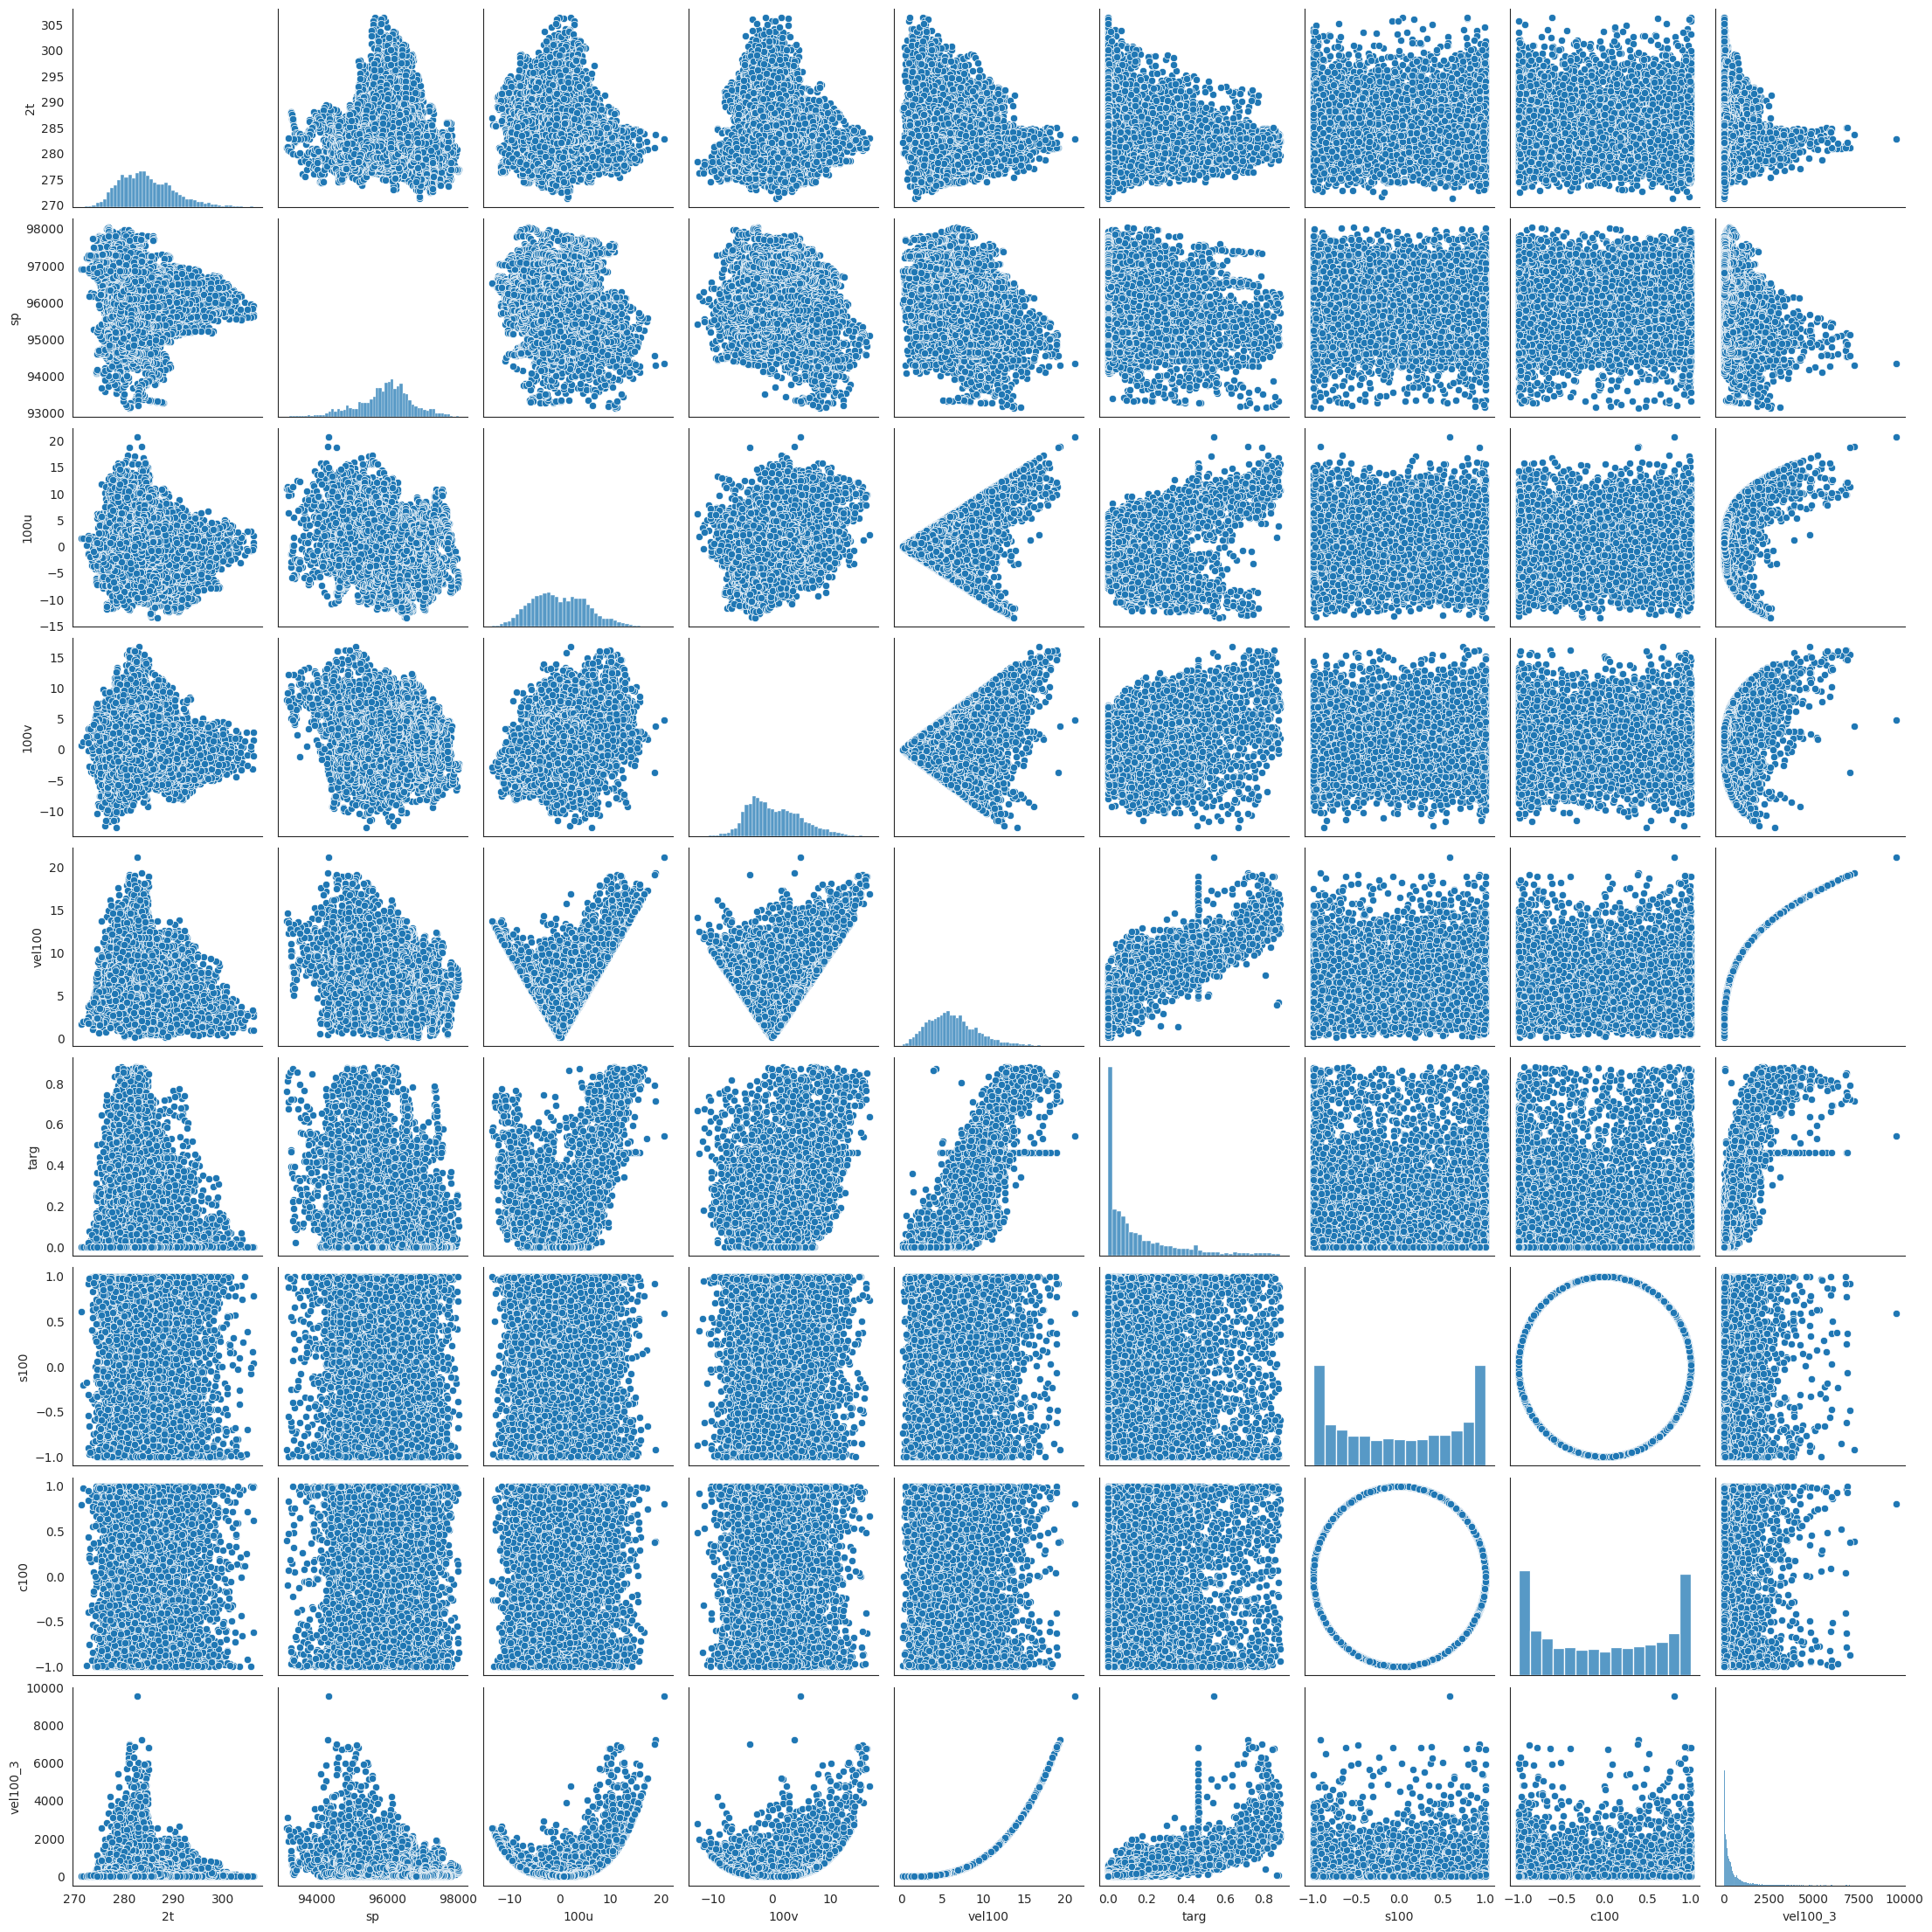

In [8]:
pair_plot = sns.pairplot(d_years['2016'])
plt.show()

## Correlations

Plot them as heatmaps and rank them against the target

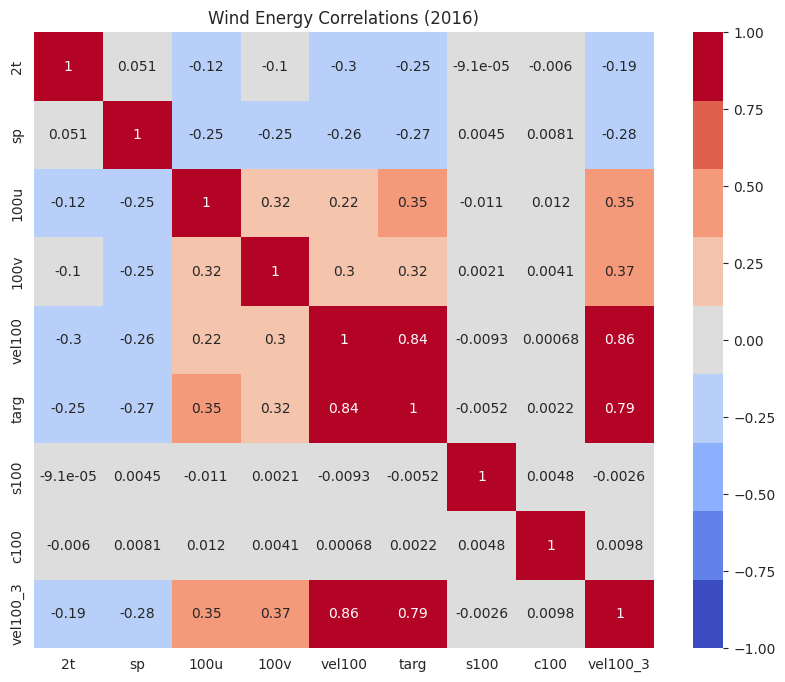

feature  correlation
1    vel100     0.840951
2  vel100_3     0.789831
3      100u     0.353517
4      100v     0.317168
5        sp     0.267355
6        2t     0.248992
7      s100     0.005178
8      c100     0.002203

In [9]:
# Heatmap de correlaciones entre todos los pares de variables
plt.figure(figsize=(10, 8))
plt.title('Wind Energy Correlations (2016)')
_ = sns.heatmap(d_years['2016'].corr().values, vmin=-1., vmax=1., cmap=plt.get_cmap("coolwarm",lut=9), 
                xticklabels=list(d_years['2016'].columns),
                yticklabels=list(d_years['2016'].columns),
                annot=True)
plt.show()

# Correlaciones de variables con el target, ordenados (y sin el target)
rank = d_years['2016'].corr()['targ'].abs().sort_values(ascending=False).reset_index()
rank.columns = ['feature', 'correlation']
rank[rank['feature'] != 'targ']

## Conclusions from the analysis of data

De lo que podemos observar, hay dos características de los datos que tienen buena correlación con el target (sobre los datos del 2016): la velocidad absoluta del viento a $100$ metros, y su valor elevado al cubo. Según el *heatmap* mostrado en la celda anterior, las correlaciones respectivas son $0.84$ y $0.79$. La diferencia de $0.05$ entre ambas características pueden atribuirse al comportamiento obtenido por elevar datos al cubo: la desviación estándar se dispara hasta ser mayor que la media de datos, y por tanto presenta un mayor número de *outliers* (valores fuera del rango intercuartil, IQR). Dichos resultados pueden ser derivados desde el *box-plot* y la descripción inicial de los datos.

La misma relación se puede observar viendo los *scatter-plots* de pares de variables relacionados con el target, donde solo estos dos valores parecen poder ser aproximados de forma lineal (con un $\epsilon$ bastante grande). También sobre estos datos, el hacer un *scatter* contra si misma muestra la distribución de los datos, que son de forma *long-tail*: muchísimos datos en las regiones iniciales $[0.0, 0.25]$, especialmente con $targ \to 0$, y con un decrecimiento exponencial a medida que el valor (normalizado) aumenta.

Aparte de las dos características mencionadas, los datos que mayor correlación tienen con el target son los componentes del viento 100v y 100u, aunque es bastante débil con un máximo de $0.35$. El resto de valores es inferior en valor absoluto, con algunos tendiendo a cero (seno, coseno). De todas formas, estos valores no implican que las columnas deberían ser descartadas, pues podrían ser de utilidad para regresores áltamente no-lineales como los perceptrones multicapa (MLPR) y vectores de soporte (SVR). 

# Shared Data Definitions

In [10]:
# Concatenación del 2016 y 2017 para entrenamiento
windvars = ['2t', 'sp', '100u', '100v', 'vel100', 's100', 's100', 'c100', 'vel100_3']
windtarg = ['targ']
df = pd.concat([d_years['2016'], d_years['2017']])

# Datos de train y test
xtrain, ytrain = df[windvars].values, df[windtarg].values.reshape(-1,)
xtest, ytest = d_years['2018'][windvars].values, d_years['2018'][windtarg].values.reshape(-1,)

# Folds y dimension de los datos
kf = KFold(2, shuffle=False)
d = xtrain.shape[1]

# Hiperparametros MLPR
alpha_vals = [10.**k for k in range(-9, 4)]
layer_vals = [(20,),(20,20),(20,20,20),(20,20,20,20),(20,20,20,20,20)]

# Hiperparametros SVR
C_vals     = [10.**k for k in range(-3, 4)] 
gamma_vals = list(np.array([2.**k for k in range(-2, 7)]) / d)
epsilon_vals = [2.**k for k in range(-10, -2)]

# MLPRegressor

For both MLPs and SVRs we are going to use the data of years 2016 and 2027 for hyperparameter selection and the year 2018 data for testing.

To alleviate the grid search hyperparametrization cost, use the 2016 and 2017 data only with **2 folds without shuffling**.

Also
* analyze the grid search results
* test the final best model

## Hyperparameter Selection

### Search

In [11]:
param_grid = {'regressor__mlp__alpha': alpha_vals,  
              'regressor__mlp__hidden_layer_sizes': layer_vals}

mlp_estimator = gridsearch_create(
    model=MLPRegressor(tol=1.e-10, max_iter=2000),
    model_name='mlp',
    param_grid=param_grid
)

ini = time.time()
mlp_estimator.fit(xtrain, ytrain)
print("\nmlp_grid_search_time: %.2f" % ((time.time() - ini)/60.))
joblib.dump(mlp_estimator, 'mlp_gridsearch.joblib')

Fitting 2 folds for each of 65 candidates, totalling 130 fits

mlp_grid_search_time: 0.47


['mlp_gridsearch.joblib']

### Best Values

alpha_range: 0.0000000010 - 1000.000000
	best_alpha = 1.0000000000
hidden_layer_range 1 - 5
	best_hidden_layer_sizes (20, 20, 20, 20)
best_cv_mae = 0.063


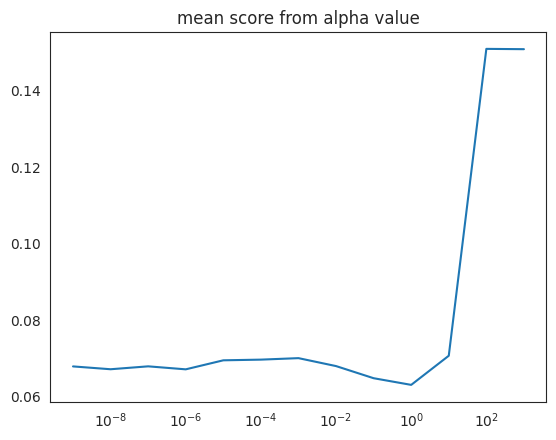

In [12]:
mlp_estimator = joblib.load('mlp_gridsearch.joblib')

print("alpha_range: %.10f - %f" % (np.array(alpha_vals).min(), np.array(alpha_vals).max()))
print("\tbest_alpha = %.10f" % (mlp_estimator.best_params_['regressor__mlp__alpha']))
print("hidden_layer_range %.d - %.d" % (len(layer_vals[0]), len(layer_vals[-1])))
print("\tbest_hidden_layer_sizes", (mlp_estimator.best_params_['regressor__mlp__hidden_layer_sizes']))
print("best_cv_mae = %.3f" % (-mlp_estimator.best_score_))

df_mlp = pd.DataFrame.from_dict(mlp_estimator.cv_results_)
idx_hl = df_mlp['param_regressor__mlp__hidden_layer_sizes'] == mlp_estimator.best_params_['regressor__mlp__hidden_layer_sizes']

plt.xscale('log')
plt.title('mean score from alpha value')
_ = plt.plot(alpha_vals, -df_mlp[idx_hl]['mean_test_score'])

### Best 5 Combinations

In [13]:
df_mlp.sort_values(by='mean_test_score', ascending=False)[['param_regressor__mlp__alpha',\
                                                          'param_regressor__mlp__hidden_layer_sizes',\
                                                          'mean_test_score']][ : 5]

param_regressor__mlp__alpha param_regressor__mlp__hidden_layer_sizes  \
48                     1.000000                         (20, 20, 20, 20)   
47                     1.000000                             (20, 20, 20)   
46                     1.000000                                 (20, 20)   
45                     1.000000                                    (20,)   
15                     0.000001                                    (20,)   

    mean_test_score  
48        -0.063049  
47        -0.063438  
46        -0.064261  
45        -0.064301  
15        -0.064324

## Training and Prediction

In [14]:
preds = []
best_mlp = mlp_estimator.best_estimator_

print("Training:", end=' ')
for i in range(20):
    print(i, end=' ')
    best_mlp.fit(xtrain, ytrain)
    preds.append(np.clip(best_mlp.predict(xtest), 0., 1.))
print()

preds = np.array(preds).T
ymean_mlp, ymedian_mlp = preds.mean(axis=1), np.median(preds, axis=1)

print("mae_mean_pred {0:9.3f}  ".format(mean_absolute_error(ytest, ymean_mlp)))
print("mae_median_pred {0:9.3f}".format(mean_absolute_error(ytest, ymedian_mlp)))

Training: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
mae_mean_pred     0.071  
mae_median_pred     0.071


## Results

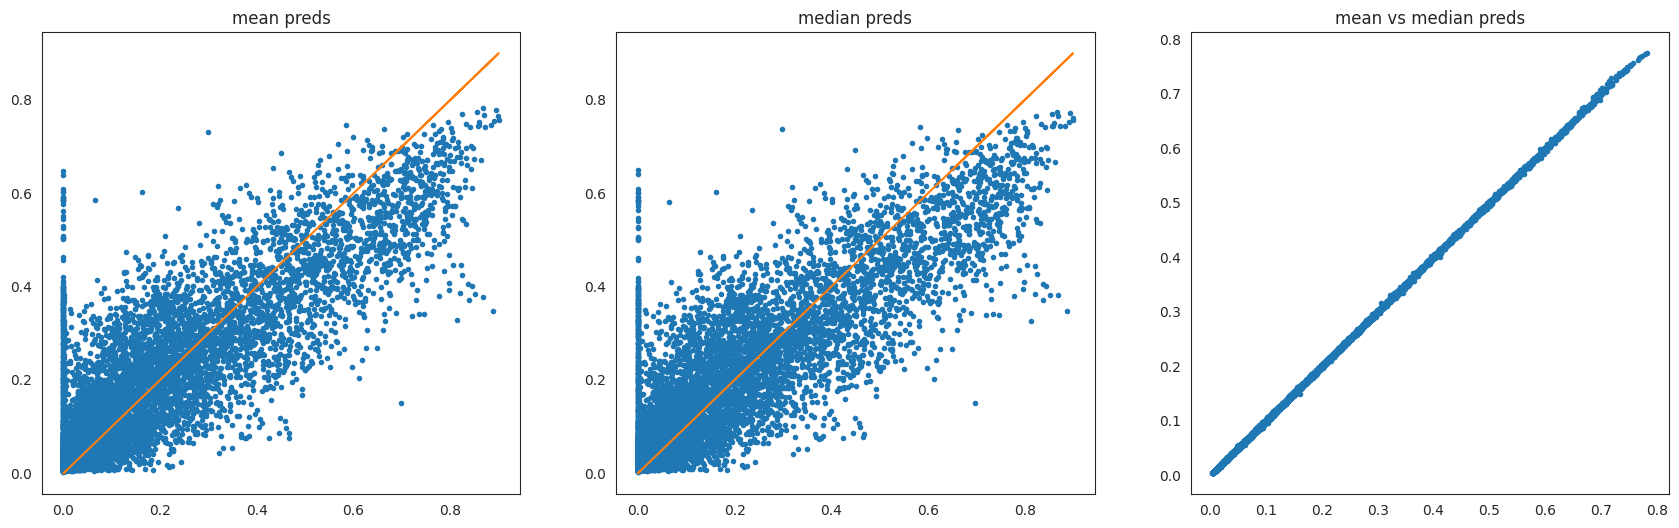

In [15]:
plt.figure(figsize=(21, 6))
plt.subplot(1, 3, 1)
plt.title('mean preds')
_ = plt.plot(ytest, ymean_mlp, '.', ytest, ytest, '-')

plt.subplot(1, 3, 2)
plt.title('median preds')
_ = plt.plot(ytest, ymedian_mlp, '.', ytest, ytest, '-')

plt.subplot(1, 3, 3)
plt.title('mean vs median preds')
_ = plt.plot(ymean_mlp, ymedian_mlp, '.')

# SV Regressor

We will work with Gaussian kernels, so we have to set two hyperparameters, `C`, `gamma` plus the `epsilon` insensitivity. We have to explore **three** hyperparameters, so search times may increase considerably.  

Again, to alleviate the grid search hyperparametrization cost, use the 2016 and 2017 data only with **2 folds without shuffling**.

Also
* analyze the grid search results
* test the final best model

## Hyperparameter Selection

### Search

In [16]:
param_grid ={'regressor__svr__C': C_vals,
             'regressor__svr__gamma': gamma_vals,
             'regressor__svr__epsilon': epsilon_vals}

svr_estimator = gridsearch_create(model=SVR(kernel='rbf', shrinking=False, tol=1.e-4, max_iter=1000),
                                  model_name='svr',
                                  param_grid=param_grid)

ini = time.time()
svr_estimator.fit(xtrain, ytrain)
print("grid_search_time: %f segundos" % (time.time() - ini))

joblib.dump(svr_estimator, "svr_gridsearch.joblib")

Fitting 2 folds for each of 504 candidates, totalling 1008 fits
grid_search_time: 2484.933579 segundos


['svr_gridsearch.joblib']

### Best Values

In [17]:
svr_estimator = joblib.load("svr_gridsearch.joblib")

print("C_range: %.4f - %.0f" % (np.array(C_vals).min(), np.array(C_vals).max()))
print('\tbest_C:', (svr_estimator.best_params_['regressor__svr__C']))

print("gamma_range: %.5f - %.5f" % (d * np.array(gamma_vals).min(), d * np.array(C_vals).max()))
print('\tbest_gamma:', (d * svr_estimator.best_params_['regressor__svr__gamma']))

print("epsilon_range: %.5f - %.3f" % (np.array(epsilon_vals).min(), np.array(epsilon_vals).max()))
print('\tbest_epsilon:', (svr_estimator.best_params_['regressor__svr__epsilon']))

C_range: 0.0010 - 1000
	best_C: 1.0
gamma_range: 0.25000 - 9000.00000
	best_gamma: 0.25
epsilon_range: 0.00098 - 0.125
	best_epsilon: 0.0009765625


### Best 5 Combinations

In [18]:
df_svr = pd.DataFrame.from_dict(svr_estimator.cv_results_)
df_svr.sort_values(by='mean_test_score', ascending=False)[['param_regressor__svr__C',\
                                                            'param_regressor__svr__gamma',\
                                                            'param_regressor__svr__epsilon',\
                                                            'mean_test_score']][ : 5]

param_regressor__svr__C  param_regressor__svr__gamma  \
216                      1.0                     0.027778   
225                      1.0                     0.027778   
243                      1.0                     0.027778   
234                      1.0                     0.027778   
252                      1.0                     0.027778   

     param_regressor__svr__epsilon  mean_test_score  
216                       0.000977        -0.061246  
225                       0.001953        -0.061247  
243                       0.007812        -0.061247  
234                       0.003906        -0.061255  
252                       0.015625        -0.061272

### Best Value Visualization

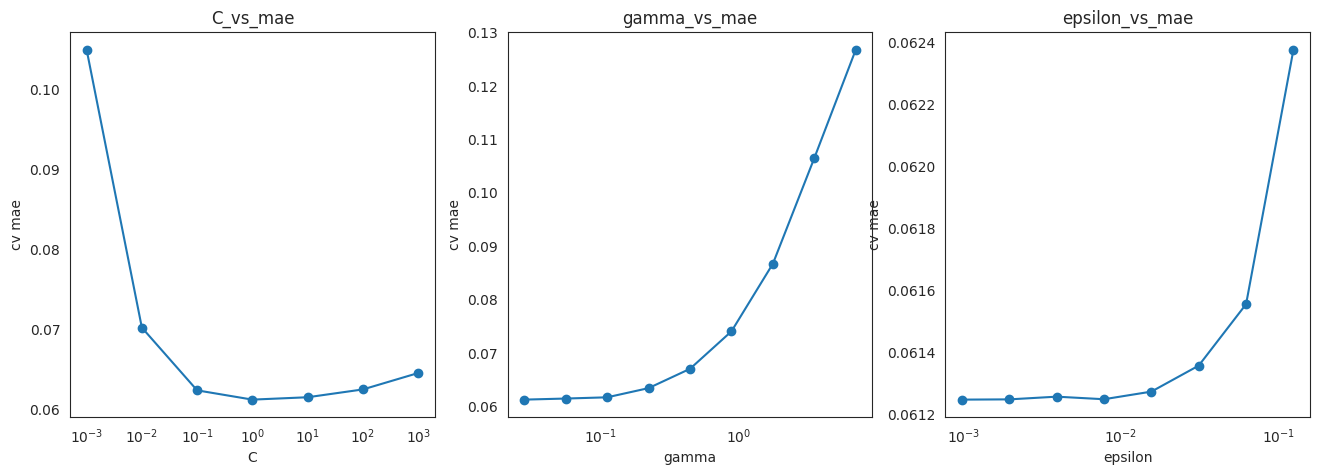

In [19]:
best_C = svr_estimator.best_params_['regressor__svr__C']
best_gamma = svr_estimator.best_params_['regressor__svr__gamma']
best_epsilon = svr_estimator.best_params_['regressor__svr__epsilon']

plt.figure(figsize=(16, 5))

comparative_plot(
    df_svr, param='C', p1='gamma', v1=best_gamma, p2='epsilon', v2=best_epsilon,
    nrows=1, ncols=3, index=1
)
comparative_plot(
    df_svr, param='gamma', p1='C', v1=best_C, p2='epsilon', v2=best_epsilon,
    nrows=1, ncols=3, index=2
)
comparative_plot(
    df_svr, param='epsilon', p1='gamma', v1=best_gamma, p2='C', v2=best_C,
    nrows=1, ncols=3, index=3
)

plt.show()

## Training and Prediction

In [20]:
best_svr = svr_estimator.best_estimator_

best_svr.fit(xtrain, ytrain)
y_svr = np.clip(best_svr.predict(xtest), 0., 1.)

print("svr_mae_pred {0:9.6f}  ".format(mean_absolute_error(ytest, y_svr)))

svr_mae_pred  0.068523  


## Results

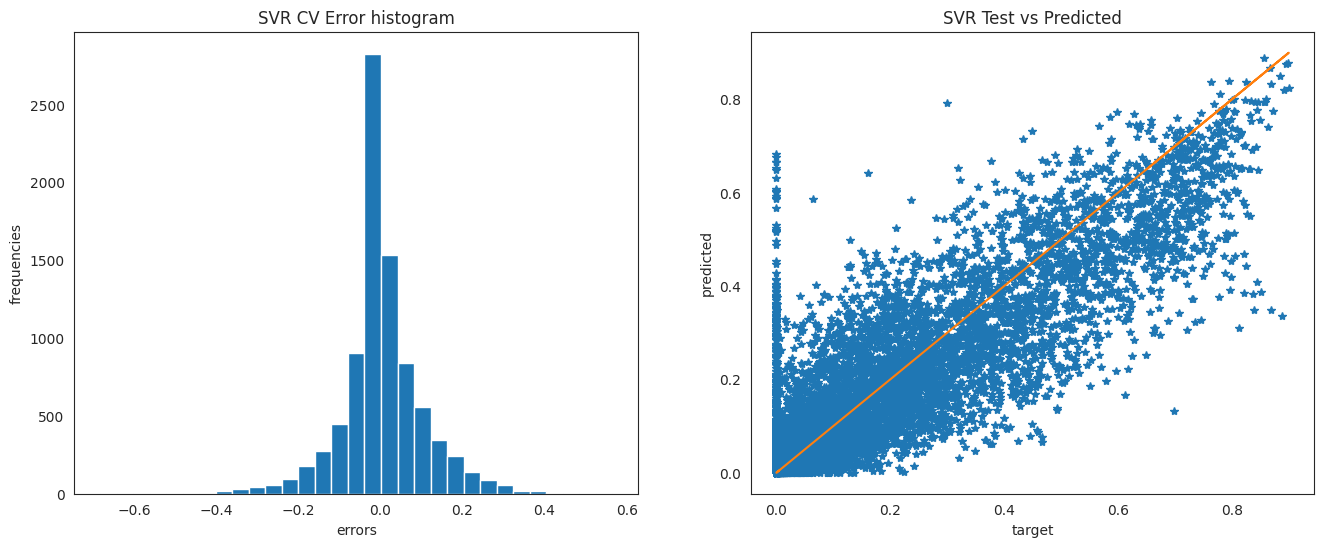

In [21]:
err = ytest - y_svr

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("SVR CV Error histogram")
plt.xlabel("errors")
plt.ylabel("frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("SVR Test vs Predicted")
plt.xlabel("target")
plt.ylabel("predicted")
_ = plt.plot(ytest, y_svr, '*', ytest, ytest, '-')

plt.show()

# MLP vs SVR comparison and conclusions

Compare both best models, discuss your results and write the conclusions you may find relevant.

Also, suggest ideas which may improve your results.

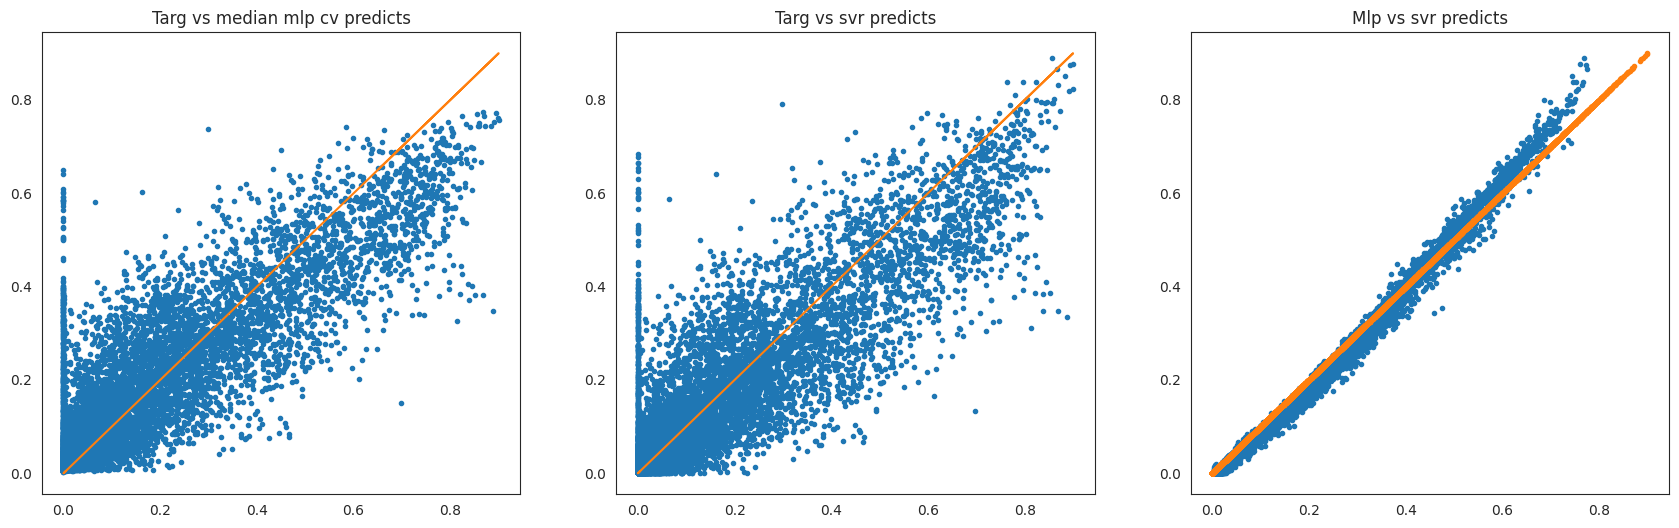

In [22]:
plt.figure(figsize=(21, 6))
plt.subplot(1, 3, 1)
plt.title('Targ vs median mlp cv predicts')
_ = plt.plot(ytest, ymedian_mlp, '.', ytest, ytest, '-')

plt.subplot(1, 3, 2)
plt.title('Targ vs svr predicts')
_ = plt.plot(ytest, y_svr, '.', ytest, ytest, '-')

plt.subplot(1, 3, 3)
plt.title('Mlp vs svr predicts')
_ = plt.plot(ymedian_mlp, y_svr, '.', ytest, ytest, '.')